In [ ]:
# This cell is only used for drawing the model architecture diagrams
# Has nothing to do with the cnn model implementation below.


import tensorflow as tf
import graphviz
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model



def conv_block(x, filters, kernel_size=(3,3), activation='relu', dropout_rate=0.3):
    x = layers.Conv2D(filters, kernel_size, padding='same', activation=activation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', activation=activation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    return x

def build_l1_model(input_shape, num_l1):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(128, (5, 5), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(128, activation='relu')(x)
    l1_out = layers.Dense(num_l1, activation='sigmoid', name='l1_output')(x)
    model = models.Model(inputs=inputs, outputs=l1_out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_l2_model(input_shape, num_l2, num_l1):
    inputs = tf.keras.Input(shape=input_shape)
    l1_predictions = tf.keras.Input(shape=(num_l1,))

    # Best L2 hyperparams found by Optuna: {'conv_filter1': 32, 'conv_filter2': 256, 'dropout_rate1': 0.19780915410166724, 'dropout_rate2': 0.47892383390812543, 'learning_rate': 0.0005251553575708384}
    conv_filter1 = 32
    conv_filter2 = 256
    dropout_rate1 = 0.19780915410166724
    dropout_rate2 = 0.47892383390812543
    learning_rate = 0.0005251553575708384

    x = layers.Conv2D(conv_filter1, (5, 5), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(dropout_rate1)(x)

    x = layers.Conv2D(conv_filter2, (2, 2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(dropout_rate2)(x)

    x = layers.Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Concatenate()([x, l1_predictions])
    x = layers.Dense(64, activation='relu')(x)
    l2_out = layers.Dense(num_l2, activation='softmax', name='l2_output')(x)

    model = models.Model(inputs=[inputs, l1_predictions], outputs=l2_out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_l3_model(input_shape, num_l3, num_l1, num_l2):
    inputs = tf.keras.Input(shape=input_shape)
    l1_predictions = tf.keras.Input(shape=(num_l1,))
    l2_predictions = tf.keras.Input(shape=(num_l2,))
    x = conv_block(inputs, 32, dropout_rate=0.3)
    x = conv_block(inputs, 64, dropout_rate=0.4)
    x = conv_block(x, 128, dropout_rate=0.3)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Concatenate()([x, l1_predictions, l2_predictions])
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    l3_out = layers.Dense(num_l3, activation='softmax', name='l3_output')(x)
    model = models.Model([inputs, l1_predictions, l2_predictions], l3_out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0009), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the number of classes
num_l1, num_l2, num_l3 = 2, 9, 19

# Build the models
conv_block = conv_block
l1_model = build_l1_model((5, 5, 105), num_l1)
l2_model = build_l2_model((5, 5, 105), num_l2, num_l1)
l3_model = build_l3_model((5, 5, 105), num_l3, num_l1, num_l2)

# Create a Graphviz diagram
def plot_custom_model(model, filename):
    dot = graphviz.Digraph(format='png')
    dot.attr(rankdir='TB')

    for layer in model.layers:
        if hasattr(layer, 'output_shape'):
            output_shape = layer.output_shape
        elif hasattr(layer, 'batch_input_shape'):
            output_shape = layer.batch_input_shape
        else:
            output_shape = 'unknown'
        dot.node(layer.name, label=f"{layer.name}\n{output_shape}", shape='box')

    for i, layer in enumerate(model.layers):
        for node in layer._inbound_nodes:
            if hasattr(node, 'inbound_layers'):
                inbound_layers = node.inbound_layers
            else:
                inbound_layers = []
                for tensor in node.input_tensors:
                    inbound_layer = tensor._keras_history.layer
                    if inbound_layer not in inbound_layers:
                        inbound_layers.append(inbound_layer)
            if not isinstance(inbound_layers, list):
                inbound_layers = [inbound_layers]
            for inbound_layer in inbound_layers:
                dot.edge(inbound_layer.name, layer.name)

    dot.render(filename)

# Plot the model architectures
plot_custom_model(l1_model, 'l1_model_custom')
plot_custom_model(l2_model, 'l2_model_custom')
plot_custom_model(l3_model, 'l3_model_custom')

AttributeError: 'KerasHistory' object has no attribute 'layer'

: 

In [1]:
import os
import ast
import h5py
import pandas as pd
import geopandas as gpd

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
input_file = "data/combined_data4.geojson"
## Read combined data
combined_gdf = gpd.read_file(input_file)

In [7]:
print(combined_gdf.head())
print(combined_gdf.crs)
print(combined_gdf.columns.to_list())
combined_gdf.crs = "EPSG:25832"
print(combined_gdf.crs)
print(combined_gdf.shape)

                     id                                                B11  \
0  00000000000000001a6a  [ [ 0.28049999475479126, 0.28049999475479126, ...   
1  00000000000000001a6b  [ [ 0.2807999849319458, 0.2807999849319458, 0....   
2  00000000000000001a6c  [ [ 0.29300001263618469, 0.29969999194145203, ...   
3  00000000000000001a6d  [ [ 0.29730001091957092, 0.30210000276565552, ...   
4  00000000000000001a6e  [ [ 0.3059999942779541, 0.3059999942779541, 0....   

                                               B11_1  \
0  [ [ 0.30849999189376831, 0.30849999189376831, ...   
1  [ [ 0.21970000863075256, 0.21970000863075256, ...   
2  [ [ 0.31360000371932983, 0.31650000810623169, ...   
3  [ [ 0.32719999551773071, 0.31650000810623169, ...   
4  [ [ 0.33559998869895935, 0.33559998869895935, ...   

                                               B11_2  \
0  [ [ 0.26954999566078186, 0.26954999566078186, ...   
1  [ [ 0.26690000295639038, 0.26690000295639038, ...   
2  [ [ 0.26550000905990601

In [9]:

# for now, we just select the NDVI, and keep id&species
select_col = ['id', 'B11', 'B11_1', 'B11_2', 'B11_3', 'B11_4', 'B11_5', 'B11_6', 'B11_7', 'B12', 'B12_1', 'B12_2', 'B12_3', 'B12_4', 'B12_5', 'B12_6', 'B12_7', 'B2', 'B2_1', 'B2_2', 'B2_3', 'B2_4', 'B2_5', 'B2_6', 'B2_7', 'B3', 'B3_1', 'B3_2', 'B3_3', 'B3_4', 'B3_5', 'B3_6', 'B3_7', 'B4', 'B4_1', 'B4_2', 'B4_3', 'B4_4', 'B4_5', 'B4_6', 'B4_7', 'B5', 'B5_1', 'B5_2', 'B5_3', 'B5_4', 'B5_5', 'B5_6', 'B5_7', 'B6', 'B6_1', 'B6_2', 'B6_3', 'B6_4', 'B6_5', 'B6_6', 'B6_7', 'B7', 'B7_1', 'B7_2', 'B7_3', 'B7_4', 'B7_5', 'B7_6', 'B7_7', 'B8', 'B8A', 'B8A_1', 'B8A_2', 'B8A_3', 'B8A_4', 'B8A_5', 'B8A_6', 'B8A_7', 'B8_1', 'B8_2', 'B8_3', 'B8_4', 'B8_5', 'B8_6', 'B8_7', 'EVI', 'EVI2', 'EVI2_1', 'EVI2_2', 'EVI2_3', 'EVI2_4', 'EVI2_5', 'EVI2_6', 'EVI2_7', 'EVI_1', 'EVI_2', 'EVI_3', 'EVI_4', 'EVI_5', 'EVI_6', 'EVI_7', 'NDVI', 'NDVI_1', 'NDVI_2', 'NDVI_3', 'NDVI_4', 'NDVI_5', 'NDVI_6', 'NDVI_7', 'NDWI', 'NDWI_1', 'NDWI_2', 'NDWI_3', 'NDWI_4', 'NDWI_5', 'NDWI_6', 'NDWI_7', 'SAVI', 'SAVI_1', 'SAVI_2', 'SAVI_3', 'SAVI_4', 'SAVI_5', 'SAVI_6', 'SAVI_7', 'l1_leaf_types', 'l2_genus', 'l3_species']
select_col_ = ['l1_leaf_types', 'l2_genus','l3_species', 'EVI', 'EVI2', 'EVI2_1', 'EVI2_2', 'EVI2_3', 'EVI2_4', 'EVI2_5', 'EVI2_6', 'EVI2_7', 'EVI_1', 'EVI_2', 'EVI_3', 'EVI_4', 'EVI_5', 'EVI_6', 'EVI_7','NDVI', 'NDVI_1', 'NDVI_2', 'NDVI_3', 'NDVI_4', 'NDVI_5', 'NDVI_6', 'NDVI_7', 'NDWI', 'NDWI_1', 'NDWI_2', 'NDWI_3', 'NDWI_4', 'NDWI_5', 'NDWI_6', 'NDWI_7', 'SAVI', 'SAVI_1', 'SAVI_2', 'SAVI_3', 'SAVI_4', 'SAVI_5', 'SAVI_6', 'SAVI_7']

select_df = combined_gdf[select_col]

nullds = select_df.isnull().sum()
print(nullds)

id                  0
B11                 0
B11_1               0
B11_2               0
B11_3               0
                 ... 
SAVI_6              9
SAVI_7           1942
l1_leaf_types       0
l2_genus            0
l3_species          0
Length: 124, dtype: int64


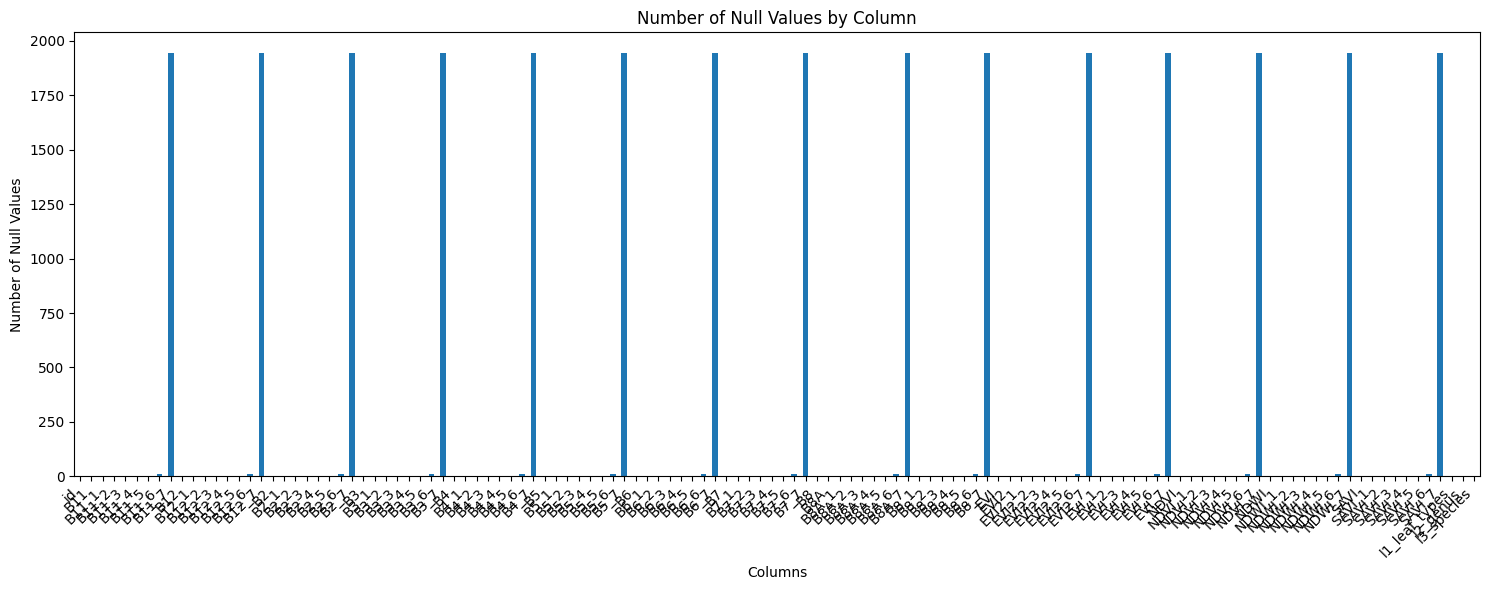

In [10]:
plt.figure(figsize=(15, 6))
nullds[nullds >= 0].plot(kind='bar')
plt.title('Number of Null Values by Column')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [11]:
# drop rows containing null values
select_df = select_df.dropna()

# drop rows containing 'none' (in any case) in any column
select_df = select_df[~select_df.apply(lambda row: row.astype(str).str.lower().eq('none').any(), axis=1)]

nullds = select_df.isnull().sum()
print(nullds)


id               0
B11              0
B11_1            0
B11_2            0
B11_3            0
                ..
SAVI_6           0
SAVI_7           0
l1_leaf_types    0
l2_genus         0
l3_species       0
Length: 124, dtype: int64


In [12]:
# load the labels
labels = np.array(select_df[['l1_leaf_types', 'l2_genus','l3_species']])
sen2 = np.array(select_df[['B11', 'B11_1', 'B11_2', 'B11_3', 'B11_4', 'B11_5', 'B11_6', 'B12', 'B12_1', 'B12_2', 'B12_3', 'B12_4', 'B12_5', 'B12_6', 'B2', 'B2_1', 'B2_2', 'B2_3', 'B2_4', 'B2_5', 'B2_6', 'B3', 'B3_1', 'B3_2', 'B3_3', 'B3_4', 'B3_5', 'B3_6', 'B4', 'B4_1', 'B4_2', 'B4_3', 'B4_4', 'B4_5', 'B4_6', 'B5', 'B5_1', 'B5_2', 'B5_3', 'B5_4', 'B5_5', 'B5_6', 'B6', 'B6_1', 'B6_2', 'B6_3', 'B6_4', 'B6_5', 'B6_6', 'B7', 'B7_1', 'B7_2', 'B7_3', 'B7_4', 'B7_5', 'B7_6', 'B8', 'B8A', 'B8A_1', 'B8A_2','B8A_3', 'B8A_4', 'B8A_5', 'B8A_6', 'B8_1', 'B8_2', 'B8_3', 'B8_4', 'B8_5', 'B8_6', 'EVI', 'EVI2', 'EVI2_1', 'EVI2_2', 'EVI2_3', 'EVI2_4', 'EVI2_5', 'EVI2_6', 'EVI_1', 'EVI_2', 'EVI_3', 'EVI_4', 'EVI_5', 'EVI_6','NDVI', 'NDVI_1', 'NDVI_2', 'NDVI_3', 'NDVI_4', 'NDVI_5', 'NDVI_6', 'NDWI', 'NDWI_1', 'NDWI_2', 'NDWI_3', 'NDWI_4', 'NDWI_5', 'NDWI_6', 'SAVI', 'SAVI_1', 'SAVI_2', 'SAVI_3', 'SAVI_4', 'SAVI_5', 'SAVI_6']])
# show the shape
print("Labels shape: " + str(labels.shape))
#print("Sen2 shape: " + str(sen2.shape))

# print the labels
print(labels[:])
print(sen2[:])
print(sen2.shape)

Labels shape: (35965, 3)
[['broadleaf' 'long-lived deciduous' 'linden']
 ['broadleaf' 'long-lived deciduous' 'linden']
 ['broadleaf' 'long-lived deciduous' 'linden']
 ...
 ['broadleaf' 'short-lived deciduous' 'alder']
 ['broadleaf' 'short-lived deciduous' 'alder']
 ['broadleaf' 'short-lived deciduous' 'alder']]
[['[ [ 0.28049999475479126, 0.28049999475479126, 0.29100000858306885, 0.29100000858306885, 0.29100000858306885 ], [ 0.29429998993873596, 0.29429998993873596, 0.29330000281333923, 0.29330000281333923, 0.29330000281333923 ], [ 0.29429998993873596, 0.29429998993873596, 0.29330000281333923, 0.29330000281333923, 0.29330000281333923 ], [ 0.28009998798370361, 0.28009998798370361, 0.27129998803138733, 0.27129998803138733, 0.27129998803138733 ], [ 0.28009998798370361, 0.28009998798370361, 0.27129998803138733, 0.27129998803138733, 0.27129998803138733 ] ]'
  '[ [ 0.30849999189376831, 0.30849999189376831, 0.31549999117851257, 0.31549999117851257, 0.31549999117851257 ], [ 0.31130000948905945

In [13]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# load the labels
labels_l1 = np.array(select_df[['l1_leaf_types']])
labels_l2 = np.array(select_df[['l2_genus']])
labels_l3 = np.array(select_df[['l3_species']])


encoder = OneHotEncoder(sparse_output=False)
labels_l1 = encoder.fit_transform(labels_l1.reshape(-1, 1))
labels_l2 = encoder.fit_transform(labels_l2.reshape(-1, 1))
labels_l3 = encoder.fit_transform(labels_l3.reshape(-1, 1))
#print("Labels shape: " + str(labels.shape))
#print("\nFirst 19 rows:")

In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import numpy as np

print("Initial shapes:")
print(f"labels_l1: {labels_l1.shape}")
print(f"labels_l2: {labels_l2.shape}")
print(f"labels_l3: {labels_l3.shape}")
print(f"sen2: {sen2.shape}")

print(labels_l1.dtype)
print(labels_l2.dtype)
print(labels_l3.dtype)
print(sen2.dtype)

Initial shapes:
labels_l1: (35965, 2)
labels_l2: (35965, 9)
labels_l3: (35965, 19)
sen2: (35965, 105)
float64
float64
float64
object


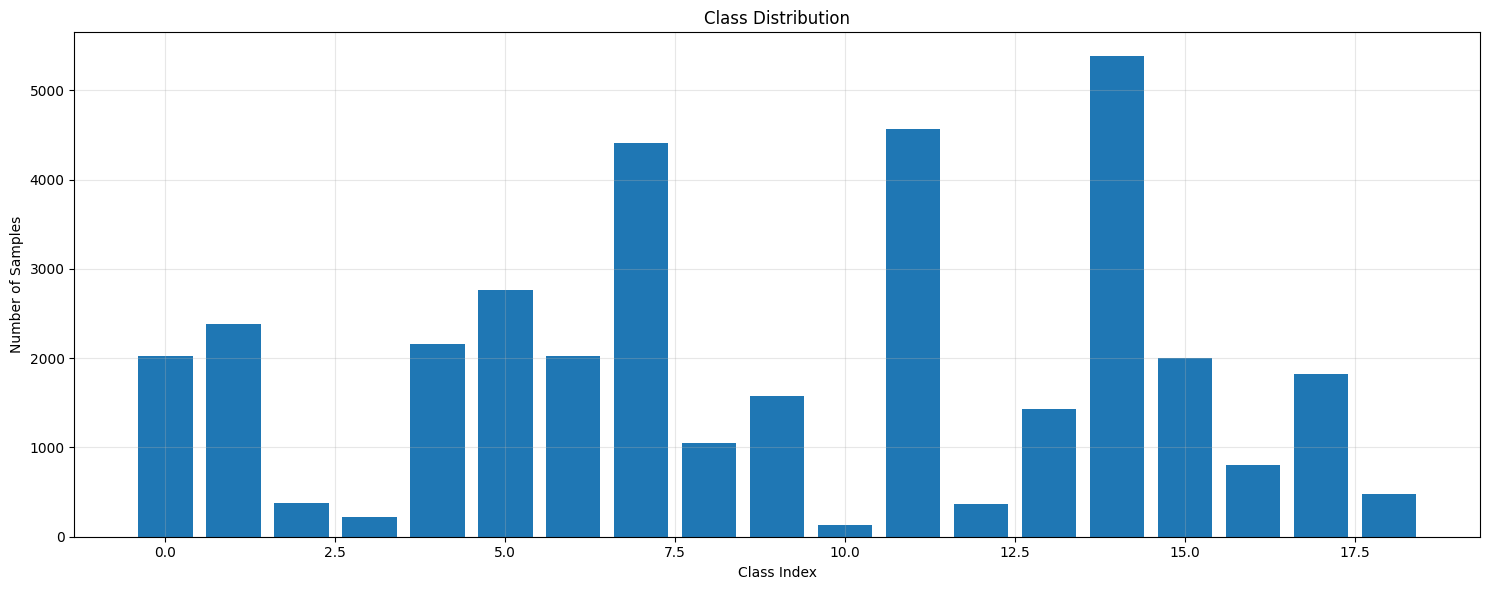

In [15]:
# Get the sum of each column (class counts)
class_sizes = np.sum(labels_l3, axis=0)

# Create a bar plot
plt.figure(figsize=(15, 6))
plt.bar(range(len(class_sizes)), class_sizes)

# Add labels and title
plt.title('Class Distribution')
plt.xlabel('Class Index')
plt.ylabel('Number of Samples')

# Adjust layout
plt.tight_layout()

# Add grid for better readability
plt.grid(True, alpha=0.3)

In [ ]:
# Convert string representation of arrays to actual numpy arrays
def convert_string_to_array(s):
	array_data = ast.literal_eval(s)
	return np.array(array_data)

# Convert all elements in sen2 to numpy arrays
sen2_arrays = np.array([convert_string_to_array(x) for x in sen2.flatten()])
number_samples = sen2.shape[0]
sen2_reshaped = sen2_arrays.reshape(number_samples, -1)

print("Post-processed Sentinel-2 data shape: ", sen2_reshaped.shape)

Post-processed Sentinel-2 data shape:  (35965, 2625)


In [ ]:
from imblearn.over_sampling import SMOTE

# dictionary for multiple classes
sampling_strategy = {
    0: 6000,
    1: 4000,
    2: 4000,  
    3: 4000,
    4: 5000,  
    5: 5000,   
    6: 5000,
    7: 5000,
    8: 5000,
    9: 5000,
    10: 5000,
    11: 6200,
    12: 5000,
    13: 5000,
    14: 6200,
    15: 3500,
    16: 3500,
    17: 3500,
    18: 5000
}

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, l3_resampled = smote.fit_resample(sen2_reshaped, np.argmax(labels_l3, axis=1))


labels_l3_resampled = encoder.fit_transform(l3_resampled.reshape(-1, 1))

Resampled shapes: (90900, 2625) (90900, 19)


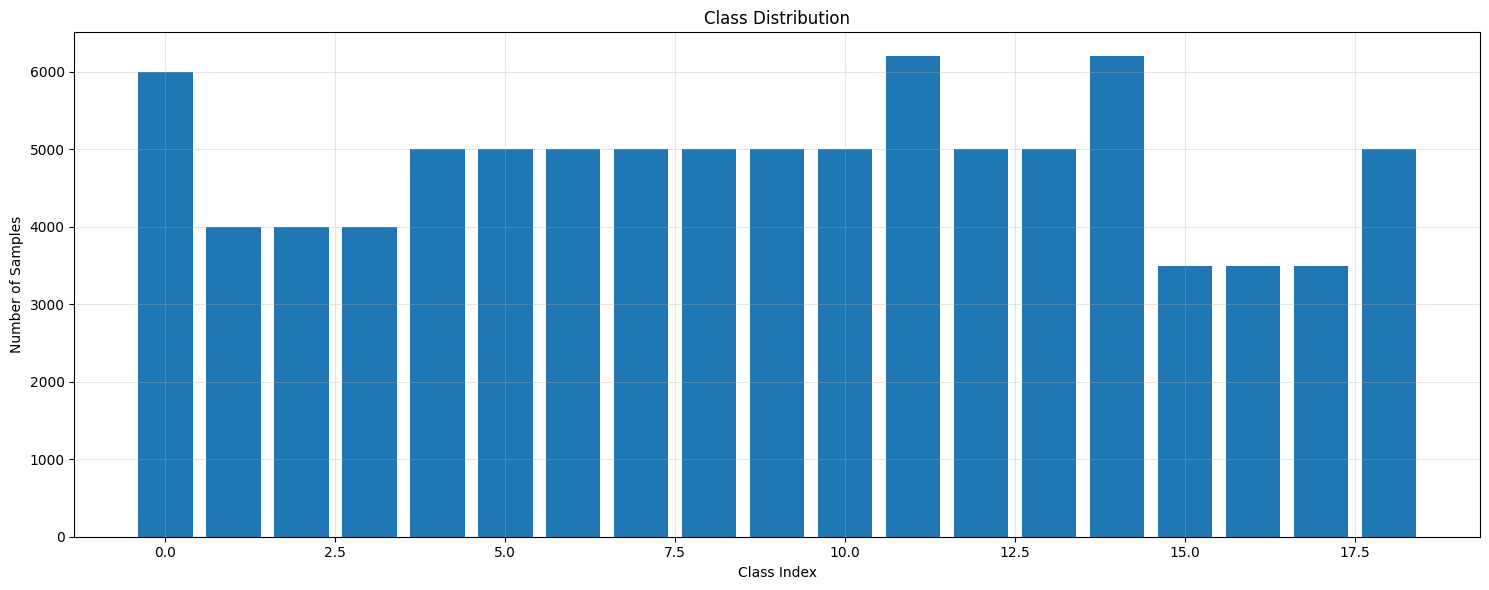

In [ ]:
print("Resampled shapes:", X_resampled.shape, labels_l3_resampled.shape)

# Get the sum of each column (class counts)
class_sizes = np.sum(labels_l3_resampled, axis=0)

# Create a bar plot
plt.figure(figsize=(15, 6))
plt.bar(range(len(class_sizes)), class_sizes)

plt.title('Class Distribution')
plt.xlabel('Class Index')
plt.ylabel('Number of Samples')

plt.tight_layout()

plt.grid(True, alpha=0.3)

Resampled shapes: (90900, 19)
Resampled shapes: (90900, 2) (90900, 9)


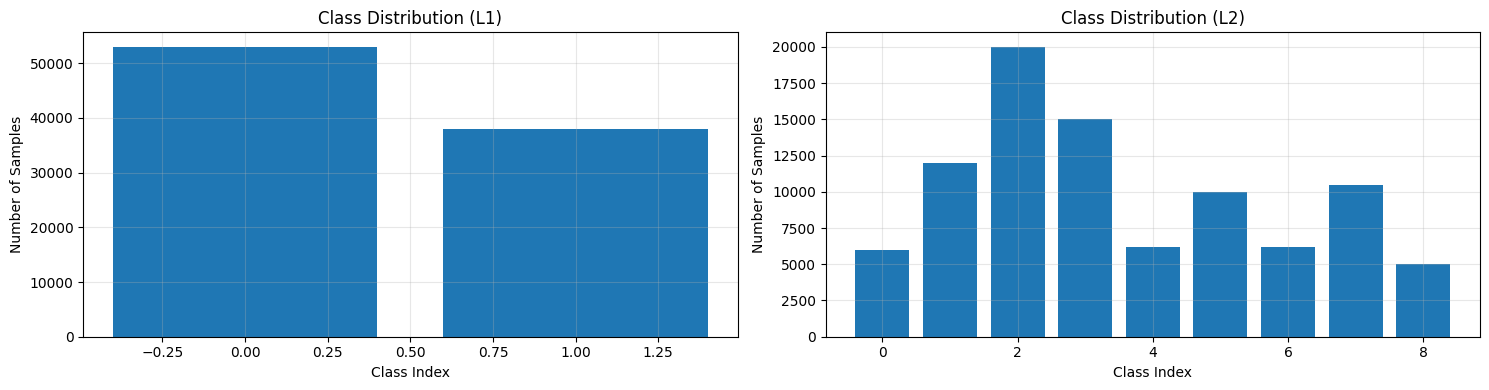

In [21]:
# 0 -> 0, 1 ,2, 3
  # 0 -> 0
  # 1 -> 1, 2, 3
  # 2 -> 4, 5, 6, 7
  # 3 -> 8, 9, 10
# 1 -> 4, 5, 6, 7, 8
  # 4 -> 11
  # 5 -> 12, 13
  # 6 -> 14
  # 7 -> 15, 16 ,17
  # 8 -> 18


l3_to_l2_l1 = {
    0: (0, 0),  # "european beech" -> beech -> broadleaf
    1: (1, 0),  # "sessile oak"    -> oak   -> broadleaf
    2: (1, 0),  # "english oak"    -> oak   -> broadleaf
    3: (1, 0),  # "red oak"        -> oak   -> broadleaf
    4: (2, 0),  # "sycamore maple" -> long-lived dec. -> broadleaf
    5: (2, 0),  # “european ash”   -> long-lived dec. -> broadleaf
    6: (2, 0),
    7: (2, 0),
    8: (3, 0),
    9: (3, 0),
    10: (3, 0),
    # ...
    11: (4, 1), # "silver birch"   -> birch -> broadleaf
    12: (5, 1),
    13: (5, 1),
    14: (6, 1), # "norway spruce"  -> spruce -> needleleaf
    15: (7, 1), # "scots pine"     -> pine   -> needleleaf
    16: (7, 1), # "black pine"     -> pine   -> needleleaf
    17: (7, 1), # "weymouth pine"  -> pine   -> needleleaf
    18: (8, 1)  # "douglas fir"    -> douglas fir -> needleleaf
}

# Initialize resampled labels with the same number of rows as labels_l3_resampled
num_samples = labels_l3_resampled.shape[0]
num_l1_classes = labels_l1.shape[1]
num_l2_classes = labels_l2.shape[1]

labels_l1_resampled = np.zeros((num_samples, num_l1_classes))
labels_l2_resampled = np.zeros((num_samples, num_l2_classes))


for i in range(len(labels_l3_resampled)):
    l3_onehot = labels_l3_resampled[i]
    l3_idx = np.argmax(l3_onehot)  # which species is 1
    (correct_l2_idx, correct_l1_idx) = l3_to_l2_l1[l3_idx]

    # Zero out and set the corrected one-hot for L2
    labels_l2_resampled[i, :] = 0
    labels_l2_resampled[i, correct_l2_idx] = 1
    
    # Zero out and set the corrected one-hot for L1
    labels_l1_resampled[i, :] = 0
    labels_l1_resampled[i, correct_l1_idx] = 1

print("Resampled shapes:", labels_l3_resampled.shape)
print("Resampled shapes:", labels_l1_resampled.shape, labels_l2_resampled.shape)
# Get the sum of each column (class counts)
plt.figure(figsize=(15, 4))

# Plot for labels_l1_resampled
plt.subplot(1, 2, 1)
class_sizes_l1 = np.sum(labels_l1_resampled, axis=0)
plt.bar(range(len(class_sizes_l1)), class_sizes_l1)
plt.title('Class Distribution (L1)')
plt.xlabel('Class Index')
plt.ylabel('Number of Samples')
plt.grid(True, alpha=0.3)

# Plot for labels_l2_resampled
plt.subplot(1, 2, 2)
class_sizes_l2 = np.sum(labels_l2_resampled, axis=0)
plt.bar(range(len(class_sizes_l2)), class_sizes_l2)
plt.title('Class Distribution (L2)')
plt.xlabel('Class Index')
plt.ylabel('Number of Samples')
plt.grid(True, alpha=0.3)

plt.tight_layout()

In [23]:
# These variables are already properly assigned in previous cells.
# We'll just verify the shapes here for correctness:
print("X_resampled:", X_resampled.shape)
print("labels_l1_resampled:", labels_l1_resampled.shape)
print("labels_l2_resampled:", labels_l2_resampled.shape)
print("labels_l3_resampled:", labels_l3_resampled.shape)
# Verify that the concatenated dataset maintains the correct entities in rows
# We will check a few random samples to ensure that the labels and features match

# Select random indices to check
random_indices = np.random.choice(X_resampled.shape[0], size=5, replace=False)

for idx in random_indices:
    print(f"Index: {idx}")
    print(f"Features: {X_resampled[idx]}")
    print(f"L1 Label: {labels_l1_resampled[idx]}")
    print(f"L2 Label: {labels_l2_resampled[idx]}")
    print(f"L3 Label: {labels_l3_resampled[idx]}")
    print("\n")

X_resampled: (90900, 2625)
labels_l1_resampled: (90900, 2)
labels_l2_resampled: (90900, 9)
labels_l3_resampled: (90900, 19)
Index: 5174
Features: [0.2058     0.2058     0.19855    ... 0.3994646  0.40543361 0.40543361]
L1 Label: [1. 0.]
L2 Label: [0. 0. 1. 0. 0. 0. 0. 0. 0.]
L3 Label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Index: 54854
Features: [0.28767475 0.28192667 0.28192667 ... 0.50271362 0.50879764 0.51193798]
L1 Label: [1. 0.]
L2 Label: [0. 0. 1. 0. 0. 0. 0. 0. 0.]
L3 Label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Index: 33500
Features: [0.21005   0.21785   0.21785   ... 0.3132746 0.3043202 0.3043202]
L1 Label: [0. 1.]
L2 Label: [0. 0. 0. 0. 0. 0. 1. 0. 0.]
L3 Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Index: 6374
Features: [0.38029999 0.38029999 0.38029999 ... 0.40885084 0.42851048 0.42851048]
L1 Label: [0. 1.]
L2 Label: [0. 0. 0. 0. 0. 1. 0. 0. 0.]
L3 Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0

In [24]:
print("X_resampled:", X_resampled.shape) # X_resampled: (97400, 2625)
X_resampled_reshaped = X_resampled.reshape(-1, 5, 5, X_resampled.shape[1] // 25)
print("X_resampled_reshaped:", X_resampled_reshaped.shape)

X_resampled: (90900, 2625)
X_resampled_reshaped: (90900, 5, 5, 105)


In [25]:
# No need to run this cell
def parse_sentinel_arrays(X_resampled):
    parsed_samples = []
    for i in range(X_resampled.shape[0]):
        # Each row → parse 120 columns into float arrays, each 5x5
        bands = []
        for j in range(X_resampled.shape[1]):
            arr_2d = np.array(ast.literal_eval(X_resampled[i, j]), dtype=np.float64)  # shape (5,5)
            bands.append(arr_2d)
        # Stack => shape (5,5,120)
        sample_3d = np.stack(bands, axis=-1)
        parsed_samples.append(sample_3d)
    return np.array(parsed_samples)  # shape (num_samples, 5, 5, 120)

# Example usage
X = parse_sentinel_arrays(X_resampled)
print(X.shape)          # Expect (26268, 5, 5, 120)
print(X[0, :, :, 0])    # Check one band of the first sample
print(X.dtype)          # Ensure float type

ValueError: malformed node or string: 0.28049999475479126

Here


In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Approach: Hierarchical Model where models are trained sequentially
def build_l1_model(input_shape, num_l1):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (5,5), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(128, (2,2), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    l1_out = layers.Dense(num_l1, activation='sigmoid', name='l1_output')(x)
    model = models.Model(inputs=inputs, outputs=l1_out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_l2_model(input_shape, num_l2, num_l1):
    inputs = tf.keras.Input(shape=input_shape)
    l1_predictions = tf.keras.Input(shape=(num_l1,))
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, (5,), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Concatenate()([x, l1_predictions])
    x = layers.Dense(64, activation='relu')(x)
    l2_out = layers.Dense(num_l2, activation='softmax', name='l2_output')(x)
    model = models.Model(inputs=[inputs, l1_predictions], outputs=l2_out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_l3_model(input_shape, num_l3, num_l1, num_l2):
    inputs = tf.keras.Input(shape=input_shape)
    l1_predictions = tf.keras.Input(shape=(num_l1,))
    l2_predictions = tf.keras.Input(shape=(num_l2,))
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Concatenate()([x, l1_predictions, l2_predictions])
    x = layers.Dense(128, activation='relu')(x)
    l3_out = layers.Dense(num_l3, activation='softmax', name='l3_output')(x)
    model = models.Model(inputs=[inputs, l1_predictions, l2_predictions], outputs=l3_out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [27]:
X, labels_l1_resampled, labels_l2_resampled, labels_l3_resampled = X_resampled_reshaped, labels_l1_resampled, labels_l2_resampled, labels_l3_resampled

# Split the data into training and testing sets
X_train, X_test, y_l1_train, y_l1_test, y_l2_train, y_l2_test, y_l3_train, y_l3_test = train_test_split(
    X, labels_l1_resampled, labels_l2_resampled, labels_l3_resampled, test_size=0.2, random_state=42)

print("Training data shapes:", X_train.shape, y_l1_train.shape, y_l2_train.shape, y_l3_train.shape)

Training data shapes: (72720, 5, 5, 105) (72720, 2) (72720, 9) (72720, 19)


Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_96 (InputLayer)     │ (None, 5, 5, 105)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_264 (Conv2D)             │ (None, 5, 5, 32)       │        30,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_136               │ (None, 2, 2, 32)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_174 (Dropout)           │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_265 (Conv2D)             │ (None, 2, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_137               │ (None, 1, 1, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_175 (Dropout)           │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_266 (Conv2D)             │ (None, 1, 1, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_48     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l1_output (Dense)               │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,466 (1.03 MB)

 Trainable params: 270,466 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_97      │ (None, 5, 5, 105) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_267 (Conv2D) │ (None, 5, 5, 32)  │     84,032 │ input_layer_97[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_138   │ (None, 2, 2, 32)  │          0 │ conv2d_267[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_176         │ (None, 2, 2, 32)  │          0 │ max_pooling2d_13… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_268 (Conv2D) │ (None, 2, 2, 256) │     33,024 │ dropout_176[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_139   │ (None, 1, 1, 256) │          0 │ conv2d_268[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_177         │ (None, 1, 1, 256) │          0 │ max_pooling2d_13… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_269 (Conv2D) │ (None, 1, 1, 128) │    131,200 │ dropout_177[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_269[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_98      │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_32      │ (None, 130)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ input_layer_98[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 64)        │      8,384 │ concatenate_32[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l2_output (Dense)   │ (None, 9)         │        585 │ dense_49[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 257,225 (1004.79 KB)

 Trainable params: 257,225 (1004.79 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_99      │ (None, 5, 5, 105) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_272 (Conv2D) │ (None, 5, 5, 64)  │     60,544 │ input_layer_99[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 64)  │        256 │ conv2d_272[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_273 (Conv2D) │ (None, 5, 5, 64)  │     36,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 64)  │        256 │ conv2d_273[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_141   │ (None, 2, 2, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_179         │ (None, 2, 2, 64)  │          0 │ max_pooling2d_14… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_274 (Conv2D) │ (None, 2, 2, 128) │     73,856 │ dropout_179[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 128) │        512 │ conv2d_274[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_275 (Conv2D) │ (None, 2, 2, 128) │    147,584 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 128) │        512 │ conv2d_275[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_142   │ (None, 1, 1, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_180         │ (None, 1, 1, 128) │          0 │ max_pooling2d_14… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ dropout_180[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_100     │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_101     │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_33      │ (None, 139)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ input_layer_100[… │
│                     │                   │            │ input_layer_101[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 128)       │     17,920 │ concatenate_33[0

 Total params: 340,819 (1.30 MB)

 Trainable params: 340,051 (1.30 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.6284 - loss: 0.6507 - val_accuracy: 0.6920 - val_loss: 0.6027
Epoch 2/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6791 - loss: 0.6128 - val_accuracy: 0.7139 - val_loss: 0.5783
Epoch 3/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6950 - loss: 0.5972 - val_accuracy: 0.7280 - val_loss: 0.5778
Epoch 4/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7062 - loss: 0.5835 - val_accuracy: 0.7310 - val_loss: 0.5544
Epoch 5/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7121 - loss: 0.5787 - val_accuracy: 0.7180 - val_loss: 0.5636
Epoch 6/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7160 - loss: 0.5732 - val_accuracy: 0.7112 - val_loss: 0.5771
Epoch 7/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7193 - loss: 0.5684 - val_accuracy: 0.7213 - val_loss: 0.5716
Epoch 8/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7223 - loss: 0.5648 -

c:\Users\berky\.conda\envs\dseo\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1097', 'keras_tensor_1098']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1818/1818 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.2157 - loss: 2.6350 - val_accuracy: 0.3442 - val_loss: 1.7355
Epoch 2/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3193 - loss: 2.2042 - val_accuracy: 0.3810 - val_loss: 1.5983
Epoch 3/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3585 - loss: 2.0812 - val_accuracy: 0.3742 - val_loss: 1.6236
Epoch 4/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3806 - loss: 1.9979 - val_accuracy: 0.3945 - val_loss: 1.5582
Epoch 5/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3979 - loss: 1.9515 - val_accuracy: 0.4478 - val_loss: 1.4521
Epoch 6/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4240 - loss: 1.8774 - val_accuracy: 0.4878 - val_loss: 1.3854
Epoch 7/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4367 - loss: 1.8344 - val_accuracy: 0.4873 - val_loss: 1.3589
Epoch 8/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4569 - loss: 1.7798 - val_accurac

c:\Users\berky\.conda\envs\dseo\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1110', 'keras_tensor_1111', 'keras_tensor_1112']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


1818/1818 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.2015 - loss: 2.5372 - val_accuracy: 0.3579 - val_loss: 1.9061
Epoch 2/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4426 - loss: 1.7430 - val_accuracy: 0.4932 - val_loss: 1.5330
Epoch 3/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4974 - loss: 1.5695 - val_accuracy: 0.4301 - val_loss: 1.8197
Epoch 4/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5300 - loss: 1.4618 - val_accuracy: 0.4915 - val_loss: 1.5116
Epoch 5/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5568 - loss: 1.3836 - val_accuracy: 0.4218 - val_loss: 1.8655
Epoch 6/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5805 - loss: 1.3045 - val_accuracy: 0.5640 - val_loss: 1.3206
Epoch 7/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5987 - loss: 1.2487 - val_accuracy: 0.6007 - val_loss: 1.2314
Epoch 8/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.6192 - loss: 1.1849 - val

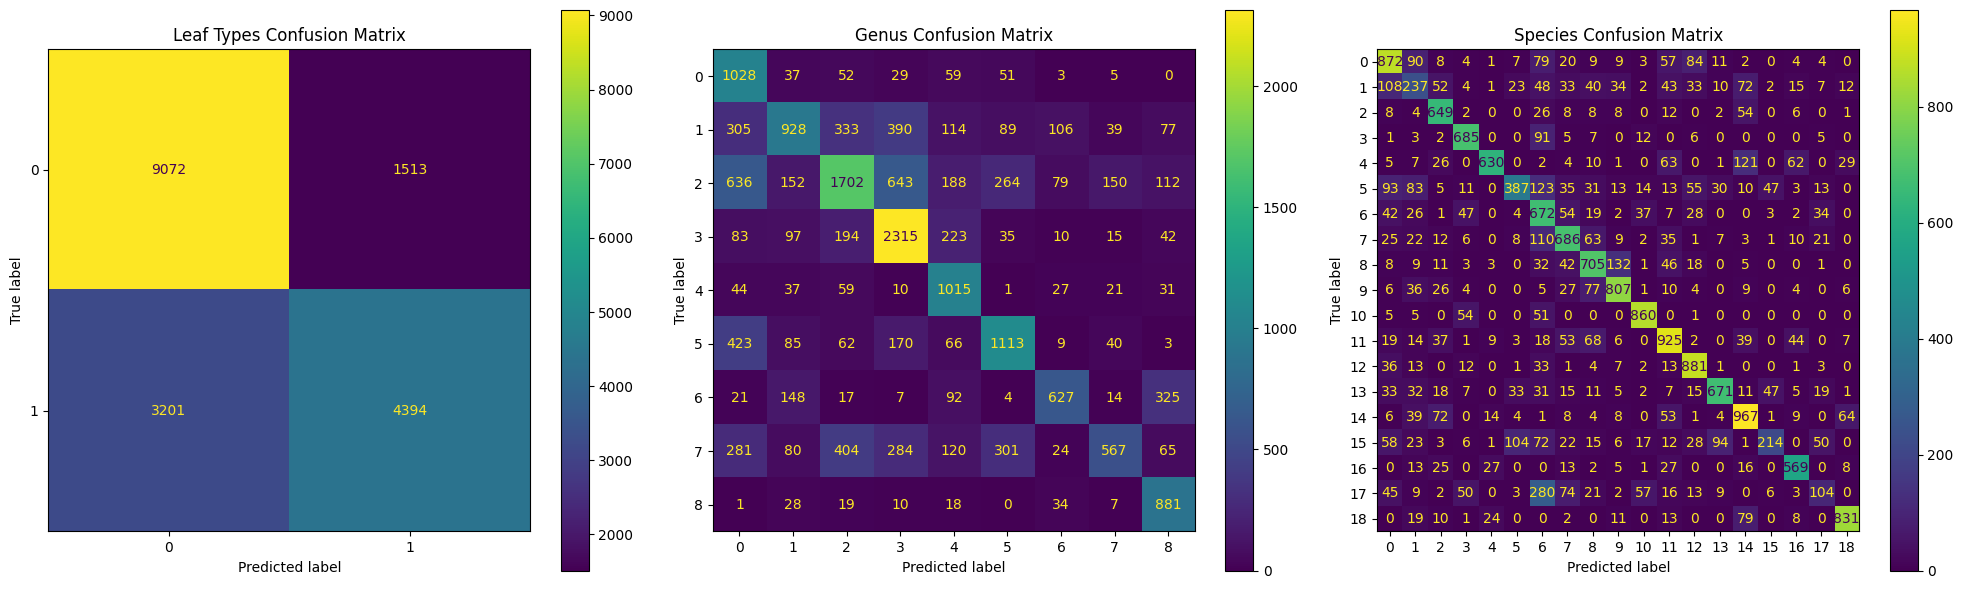

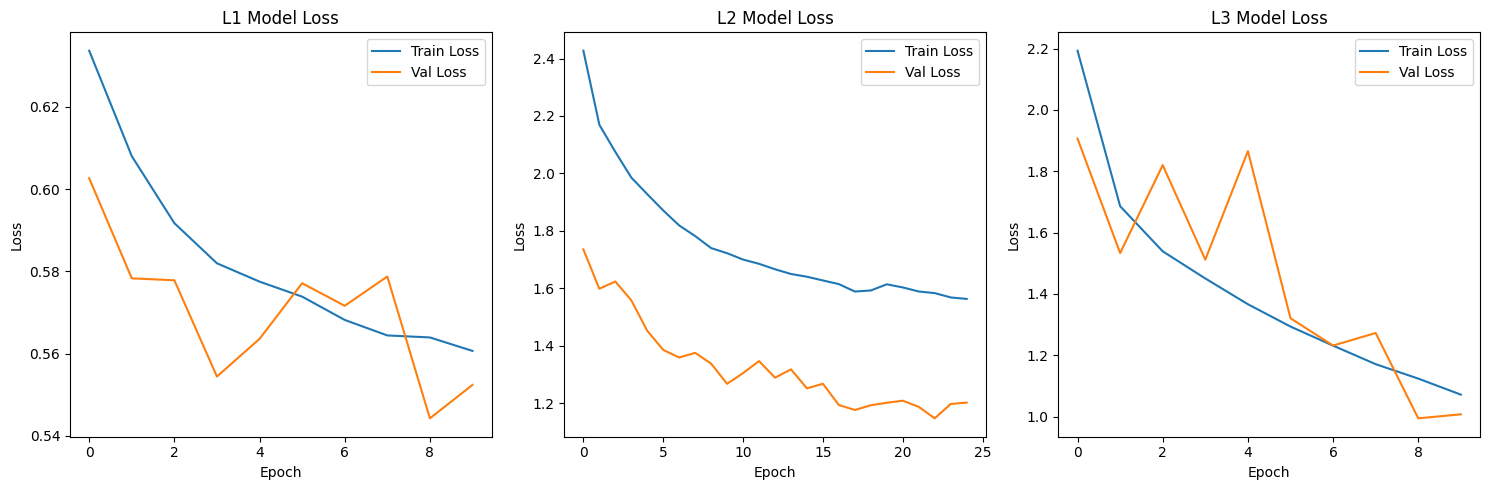

In [74]:
import tensorflow as tf
from tensorflow.keras import layers, models
import optuna

def conv_block(x, filters, kernel_size=(3,3), activation='relu', dropout_rate=0.3):
    x = layers.Conv2D(filters, kernel_size, padding='same', activation=activation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', activation=activation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    return x

def build_l1_model(input_shape, num_l1):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(128, (5, 5), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    l1_out = layers.Dense(num_l1, activation='sigmoid', name='l1_output')(x)
    model = models.Model(inputs=inputs, outputs=l1_out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_l2_model(input_shape, num_l2, num_l1):
    inputs = tf.keras.Input(shape=input_shape)
    l1_predictions = tf.keras.Input(shape=(num_l1,))

    # Best L2 hyperparams found by Optuna: {'conv_filter1': 32, 'conv_filter2': 256, 'dropout_rate1': 0.19780915410166724, 'dropout_rate2': 0.47892383390812543, 'learning_rate': 0.0005251553575708384}
    conv_filter1 = 32
    conv_filter2 = 256
    dropout_rate1 = 0.19780915410166724
    dropout_rate2 = 0.47892383390812543
    learning_rate = 0.0005251553575708384

    x = layers.Conv2D(conv_filter1, (5, 5), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(dropout_rate1)(x)

    x = layers.Conv2D(conv_filter2, (2, 2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(dropout_rate2)(x)

    x = layers.Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Concatenate()([x, l1_predictions])
    x = layers.Dense(64, activation='relu')(x)
    l2_out = layers.Dense(num_l2, activation='softmax', name='l2_output')(x)

    model = models.Model(inputs=[inputs, l1_predictions], outputs=l2_out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_l3_model(input_shape, num_l3, num_l1, num_l2):
    inputs = tf.keras.Input(shape=input_shape)
    l1_predictions = tf.keras.Input(shape=(num_l1,))
    l2_predictions = tf.keras.Input(shape=(num_l2,))
    x = conv_block(inputs, 32, dropout_rate=0.3)
    x = conv_block(inputs, 64, dropout_rate=0.4)
    x = conv_block(x, 128, dropout_rate=0.3)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Concatenate()([x, l1_predictions, l2_predictions])
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    l3_out = layers.Dense(num_l3, activation='softmax', name='l3_output')(x)
    model = models.Model([inputs, l1_predictions, l2_predictions], l3_out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0009), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the number of classes
num_l1, num_l2, num_l3 = 2, 9, 19

# Build the models
l1_model = build_l1_model((5, 5, 105), num_l1)
l2_model = build_l2_model((5, 5, 105), num_l2, num_l1)
l3_model = build_l3_model((5, 5, 105), num_l3, num_l1, num_l2)


# Summary
l1_model.summary()
l2_model.summary()
l3_model.summary()


# Define class weights for each output if you know imbalance distribution
class_weight_l1 = {0: 1.0, 1: 1.0}
class_weight_l2 = {0: 3.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 3.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 3.0}   # example
class_weight_l3 = {0: 2.5, 1: 2.0, 2: 5.0, 3: 5.0, 4: 2.0, 5: 2.0, 6: 2.0, 7: 1.0, 8: 5.0, 9: 1.0, 10: 5.0, 11: 1.0, 12: 5.0, 13: 4.5, 14: 1.0, 15: 4.5, 16: 5.0, 17: 4.5, 18: 5.0}   # example

# Custom training loop
epochs = 10
batch_size = 32

# Ensure labels are one-hot encoded
y_l1_train = np.array(y_l1_train)  # Ensure it's a NumPy array
y_l1_test = np.array(y_l1_test)
y_l2_train = np.array(y_l2_train)
y_l2_test = np.array(y_l2_test)
y_l3_train = np.array(y_l3_train)
y_l3_test = np.array(y_l3_test)

# Train L1 model
l1_history = l1_model.fit(
    X_train, 
    y_l1_train, 
    class_weight=class_weight_l1,
    validation_split=0.2,
    epochs=10, 
    batch_size=batch_size,
    verbose=1
)

# Get L1 predictions for both train and test sets
l1_predictions_train = l1_model.predict(X_train)
l1_predictions_test = l1_model.predict(X_test)

# Train L2 model using L1 predictions
l2_history = l2_model.fit([X_train, l1_predictions_train], y_l2_train,
                         validation_split=0.2,
                         epochs=25,
                         class_weight = class_weight_l2,
                         batch_size=batch_size,
                         verbose=1)

# Get L2 predictions for both train and test sets
l2_predictions_train = l2_model.predict([X_train, l1_predictions_train])
l2_predictions_test = l2_model.predict([X_test, l1_predictions_test])

# Train L3 model using L1 and L2 predictions
l3_history = l3_model.fit([X_train, l1_predictions_train, l2_predictions_train], y_l3_train,
                         validation_split=0.2,
                         epochs=epochs,
                         batch_size=batch_size,
                         verbose=1)

# Get L3 predictions for both train and test sets
l3_predictions_train = l3_model.predict([X_train, l1_predictions_train, l2_predictions_train])
l3_predictions_test = l3_model.predict([X_test, l1_predictions_test, l2_predictions_test])

# Convert predictions to integer labels
l1_predictions_test_int = np.argmax(l1_predictions_test, axis=1)
l2_predictions_test_int = np.argmax(l2_predictions_test, axis=1)
l3_predictions_test_int = np.argmax(l3_predictions_test, axis=1)

# Convert true labels to integer labels
y_l1_test_int = np.argmax(y_l1_test, axis=1)
y_l2_test_int = np.argmax(y_l2_test, axis=1)
y_l3_test_int = np.argmax(y_l3_test, axis=1)

# Calculate accuracy for each level
l1_accuracy = accuracy_score(y_l1_test_int, l1_predictions_test_int)
l2_accuracy = accuracy_score(y_l2_test_int, l2_predictions_test_int)
l3_accuracy = accuracy_score(y_l3_test_int, l3_predictions_test_int)

print("\nTest Set Accuracies:")
print(f"L1 (Leaf Types) Accuracy: {l1_accuracy:.4f}")
print(f"L2 (Genus) Accuracy: {l2_accuracy:.4f}")
print(f"L3 (Species) Accuracy: {l3_accuracy:.4f}")

# Plot confusion matrices
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ConfusionMatrixDisplay.from_predictions(y_l1_test_int, 
                                      l1_predictions_test_int,
                                      ax=ax1)
ax1.set_title('Leaf Types Confusion Matrix')

ConfusionMatrixDisplay.from_predictions(y_l2_test_int,
                                      l2_predictions_test_int,
                                      ax=ax2)
ax2.set_title('Genus Confusion Matrix')

ConfusionMatrixDisplay.from_predictions(y_l3_test_int,
                                      l3_predictions_test_int,
                                      ax=ax3)
ax3.set_title('Species Confusion Matrix')

plt.tight_layout()
plt.show()
# Plot training & validation loss for each model
plt.figure(figsize=(15, 5))

# L1 loss
plt.subplot(1, 3, 1)
plt.plot(l1_history.history['loss'], label='Train Loss')
plt.plot(l1_history.history['val_loss'], label='Val Loss')
plt.title('L1 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# L2 loss
plt.subplot(1, 3, 2)
plt.plot(l2_history.history['loss'], label='Train Loss')
plt.plot(l2_history.history['val_loss'], label='Val Loss')
plt.title('L2 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# L3 loss
plt.subplot(1, 3, 3)
plt.plot(l3_history.history['loss'], label='Train Loss')
plt.plot(l3_history.history['val_loss'], label='Val Loss')
plt.title('L3 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


c:\Users\berky\.conda\envs\dseo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 5, 105)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 5, 32)       │        84,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 2, 2, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 1, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l1_output (Dense)               │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,954 (554.51 KB)

 Trainable params: 141,954 (554.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6295 - loss: 0.6517 - val_accuracy: 0.7021 - val_loss: 0.6055
Epoch 2/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6927 - loss: 0.6028 - val_accuracy: 0.7199 - val_loss: 0.5807
Epoch 3/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6929 - loss: 0.6011 - val_accuracy: 0.7105 - val_loss: 0.5816
Epoch 4/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6955 - loss: 0.5908 - val_accuracy: 0.7204 - val_loss: 0.5608
Epoch 5/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6965 - loss: 0.5901 - val_accuracy: 0.5842 - val_loss: 0.6758
Epoch 6/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6307 - loss: 0.6520 - val_accuracy: 0.7251 - val_loss: 0.5691
Epoch 7/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6958 - loss: 0.5958 - val_accuracy: 0.7113 - val_loss: 0.5790
Epoch 8/10
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7036 - loss: 0.5826 - 

c:\Users\berky\.conda\envs\dseo\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_11', 'keras_tensor_12']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1818/1818 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.2541 - loss: 1.9021 - val_accuracy: 0.3566 - val_loss: 1.6357
Epoch 2/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3687 - loss: 1.6295 - val_accuracy: 0.4458 - val_loss: 1.4982
Epoch 3/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4216 - loss: 1.5361 - val_accuracy: 0.4855 - val_loss: 1.4211
Epoch 4/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4563 - loss: 1.4574 - val_accuracy: 0.4952 - val_loss: 1.3849
Epoch 5/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4774 - loss: 1.4136 - val_accuracy: 0.5193 - val_loss: 1.2943
Epoch 6/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4840 - loss: 1.3789 - val_accuracy: 0.5360 - val_loss: 1.2540
Epoch 7/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4994 - loss: 1.3448 - val_accuracy: 0.5380 - val_loss: 1.2754
Epoch 8/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5063 - loss: 1.3220 - val_accurac

c:\Users\berky\.conda\envs\dseo\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_24', 'keras_tensor_25', 'keras_tensor_26']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


1818/1818 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3931 - loss: 2.0021 - val_accuracy: 0.5316 - val_loss: 1.4624
Epoch 2/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5471 - loss: 1.4195 - val_accuracy: 0.5624 - val_loss: 1.3690
Epoch 3/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5692 - loss: 1.3489 - val_accuracy: 0.5765 - val_loss: 1.3116
Epoch 4/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5833 - loss: 1.2906 - val_accuracy: 0.5907 - val_loss: 1.2682
Epoch 5/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5945 - loss: 1.2715 - val_accuracy: 0.5996 - val_loss: 1.2322
Epoch 6/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6039 - loss: 1.2148 - val_accuracy: 0.6055 - val_loss: 1.2287
Epoch 7/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6160 - loss: 1.1865 - val_accuracy: 0.6159 - val_loss: 1.1784
Epoch 8/25
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6231 - loss: 1.1577 - val_accurac

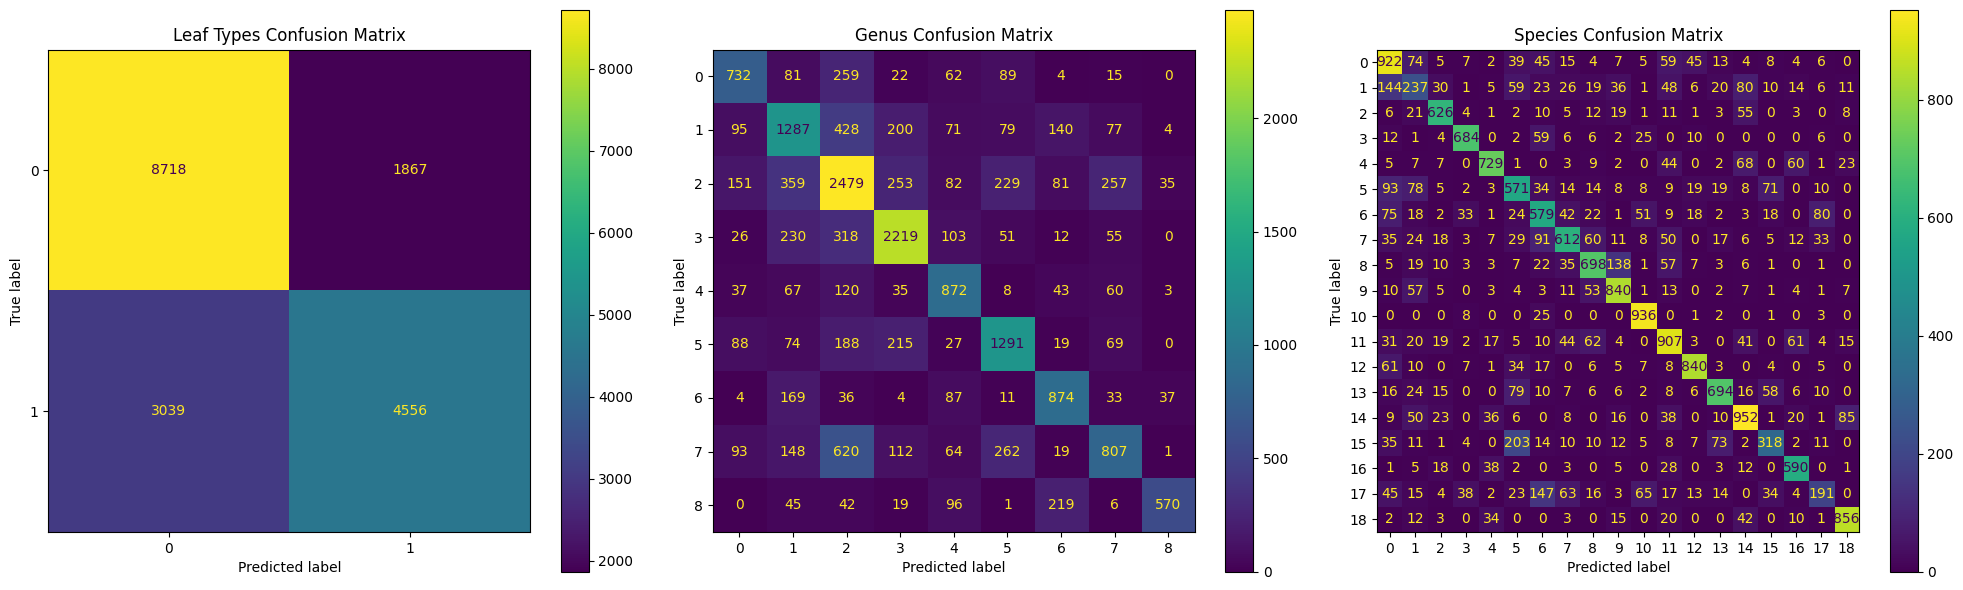

In [28]:
import optuna

# Approach: Hierarchical Model where models are trained sequentially
def build_l1_model(input_shape, num_l1):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, (2, 2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    l1_out = layers.Dense(num_l1, activation='sigmoid', name='l1_output')(x)
    model = models.Model(inputs=inputs, outputs=l1_out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_l2_model(input_shape, num_l2, num_l1):
    inputs = tf.keras.Input(shape=input_shape)
    l1_predictions = tf.keras.Input(shape=(num_l1,))

    # Best L2 hyperparams found by Optuna: {'conv_filter1': 32, 'conv_filter2': 256, 'dropout_rate1': 0.19780915410166724, 'dropout_rate2': 0.47892383390812543, 'learning_rate': 0.0005251553575708384}
    conv_filter1 = 32
    conv_filter2 = 256
    dropout_rate1 = 0.19780915410166724
    dropout_rate2 = 0.47892383390812543
    learning_rate = 0.0005251553575708384

    x = layers.Conv2D(conv_filter1, (5, 5), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(dropout_rate1)(x)

    x = layers.Conv2D(conv_filter2, (2, 2), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(dropout_rate2)(x)

    x = layers.Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Concatenate()([x, l1_predictions])
    x = layers.Dense(64, activation='relu')(x)
    l2_out = layers.Dense(num_l2, activation='softmax', name='l2_output')(x)

    model = models.Model(inputs=[inputs, l1_predictions], outputs=l2_out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_l3_model(input_shape, num_l3, num_l1, num_l2):
    inputs = tf.keras.Input(shape=input_shape)
    l1_predictions = tf.keras.Input(shape=(num_l1,))
    l2_predictions = tf.keras.Input(shape=(num_l2,))
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Concatenate()([x, l1_predictions, l2_predictions])
    x = layers.Dense(128, activation='relu')(x)
    l3_out = layers.Dense(num_l3, activation='softmax', name='l3_output')(x)
    model = models.Model(inputs=[inputs, l1_predictions, l2_predictions], outputs=l3_out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 
# Define class weights for each output if you know3 imbalance distribution
class_weight_l1 = {0: 1.0, 1: 1.0}
class_weight_l2 = {0: 3.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 3.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 3.0}   # example
class_weight_l3 = {0: 2.5, 1: 2.0, 2: 5.0, 3: 5.0, 4: 2.0, 5: 2.0, 6: 2.0, 7: 1.0, 8: 5.0, 9: 1.0, 10: 5.0, 11: 1.0, 12: 5.0, 13: 4.5, 14: 1.0, 15: 4.5, 16: 5.0, 17: 4.5, 18: 5.0}   # example

# Build models
l1_model = build_l1_model((5, 5, 105), num_l1=len(class_weight_l1))
l2_model = build_l2_model((5, 5, 105), num_l2=len(class_weight_l2), num_l1=len(class_weight_l1))
def objective_l2(trial):
    # Suggest hyperparameters
    conv_filter1 = trial.suggest_categorical('conv_filter1', [32, 64, 128])
    conv_filter2 = trial.suggest_categorical('conv_filter2', [64, 128, 256])
    dropout_rate1 = trial.suggest_float('dropout_rate1', 0.1, 0.5)
    dropout_rate2 = trial.suggest_float('dropout_rate2', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    # Build and train model
    temp_model = build_l2_model(
        input_shape=(5,5,105),
        num_l2=len(class_weight_l2),
        num_l1=len(class_weight_l1)
    )
    temp_model.layers[2].filters = conv_filter1
    temp_model.layers[5].filters = conv_filter2
    temp_model.layers[4].rate = dropout_rate1
    temp_model.layers[7].rate = dropout_rate2
    temp_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    hist = temp_model.fit(
        [X_train, l1_predictions_train], y_l2_train,
        validation_split=0.2,
        epochs=3,
        batch_size=32,
        verbose=0
    )
    return min(hist.history['val_loss'])
"""
study = optuna.create_study(direction='minimize')
study.optimize(objective_l2, n_trials=10)
best_params = study.best_params
print("Best L2 hyperparams found by Optuna:", best_params)

# Rebuild final model with best hyperparams
l2_model = build_l2_model(
    (5,5,105),
    num_l2=len(class_weight_l2),
    num_l1=len(class_weight_l1)
)
l2_model.layers[1].filters = best_params['conv_filter1']
l2_model.layers[4].filters = best_params['conv_filter2']
l2_model.layers[2].rate = best_params['dropout_rate1']
l2_model.layers[5].rate = best_params['dropout_rate2']
l2_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)"""
l3_model = build_l3_model((5, 5, 105), num_l3=len(class_weight_l3), num_l1=len(class_weight_l1), num_l2=len(class_weight_l2))
l1_model.summary()
# Custom training loop
epochs = 10
batch_size = 32
num_batches = len(X_train) // batch_size
# Ensure labels are one-hot encoded
y_l1_train = np.array(y_l1_train)  # Ensure it's a NumPy array
y_l1_test = np.array(y_l1_test)
y_l2_train = np.array(y_l2_train)
y_l2_test = np.array(y_l2_test)
y_l3_train = np.array(y_l3_train)
y_l3_test = np.array(y_l3_test)

# Compile the model with categorical_crossentropy
#l1_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
l1_history = l1_model.fit(
    X_train, 
    y_l1_train, 
    class_weight=class_weight_l1,
    validation_split=0.2,
    epochs=10, 
    batch_size=batch_size,
    verbose=1
)

# Get L1 predictions for both train and test sets
l1_predictions_train = l1_model.predict(X_train)
l1_predictions_test = l1_model.predict(X_test)

# Convert predictions to integer labels
l1_predictions_train_int = np.argmax(l1_predictions_train, axis=1)
l1_predictions_test_int = np.argmax(l1_predictions_test, axis=1)

# Convert true labels to integer labels
y_l1_train_int = np.argmax(y_l1_train, axis=1)
y_l1_test_int = np.argmax(y_l1_test, axis=1)

# Train L2 model using L1 predictions
l2_history = l2_model.fit([X_train, l1_predictions_train], y_l2_train,
                         validation_split=0.2,
                         epochs=25,
                         batch_size=batch_size,
                         verbose=1)

# Get L2 predictions for both train and test sets
l2_predictions_train = l2_model.predict([X_train, l1_predictions_train])
l2_predictions_test = l2_model.predict([X_test, l1_predictions_test])

# Convert predictions to integer labels
l2_predictions_train_int = np.argmax(l2_predictions_train, axis=1)
l2_predictions_test_int = np.argmax(l2_predictions_test, axis=1)

# Convert true labels to integer labels
y_l2_train_int = np.argmax(y_l2_train, axis=1)
y_l2_test_int = np.argmax(y_l2_test, axis=1)

# Train L3 model using L1 and L2 predictions
l3_history = l3_model.fit([X_train, l1_predictions_train, l2_predictions_train], y_l3_train,
                         validation_split=0.2,
                         epochs=25,
                         batch_size=batch_size,
                         verbose=1)

# Get L3 predictions for both train and test sets
l3_predictions_train = l3_model.predict([X_train, l1_predictions_train, l2_predictions_train])
l3_predictions_test = l3_model.predict([X_test, l1_predictions_test, l2_predictions_test])

# Convert predictions to integer labels
l3_predictions_train_int = np.argmax(l3_predictions_train, axis=1)
l3_predictions_test_int = np.argmax(l3_predictions_test, axis=1)

# Convert true labels to integer labels
y_l3_train_int = np.argmax(y_l3_train, axis=1)
y_l3_test_int = np.argmax(y_l3_test, axis=1)

# Calculate accuracy for each level
l1_accuracy = accuracy_score(y_l1_test_int, l1_predictions_test_int)
l2_accuracy = accuracy_score(y_l2_test_int, l2_predictions_test_int)
l3_accuracy = accuracy_score(y_l3_test_int, l3_predictions_test_int)

print("\nTest Set Accuracies:")
print(f"L1 (Leaf Types) Accuracy: {l1_accuracy:.4f}")
print(f"L2 (Genus) Accuracy: {l2_accuracy:.4f}")
print(f"L3 (Species) Accuracy: {l3_accuracy:.4f}")

# Plot confusion matrices
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ConfusionMatrixDisplay.from_predictions(y_l1_test_int, 
                                      l1_predictions_test_int,
                                      ax=ax1)
ax1.set_title('Leaf Types Confusion Matrix')

ConfusionMatrixDisplay.from_predictions(y_l2_test_int,
                                      l2_predictions_test_int,
                                      ax=ax2)
ax2.set_title('Genus Confusion Matrix')

ConfusionMatrixDisplay.from_predictions(y_l3_test_int,
                                      l3_predictions_test_int,
                                      ax=ax3)
ax3.set_title('Species Confusion Matrix')

plt.tight_layout()
plt.show()


In [31]:
input_file = "data/combined_data_test.geojson"
## Read combined data
combined_gdf_td = gpd.read_file(input_file)

In [32]:
print(combined_gdf_td.head())
print(combined_gdf_td.crs)
print(combined_gdf_td.columns.to_list())
combined_gdf_td.crs = "EPSG:25832"
print(combined_gdf_td.crs)
print(combined_gdf_td.shape)

                     id                                                B11  \
0  00000000000000000d5f  [ [ 0.18850000202655792, 0.18850000202655792, ...   
1  00000000000000000d60  [ [ 0.15530000627040863, 0.15530000627040863, ...   
2  00000000000000000d61  [ [ 0.19709999859333038, 0.19519999623298645, ...   
3  00000000000000000d62  [ [ 0.24719999730587006, 0.24120000004768372, ...   
4  00000000000000000d63  [ [ 0.26109999418258667, 0.26109999418258667, ...   

                                               B11_1  \
0  [ [ 0.19804999232292175, 0.19804999232292175, ...   
1  [ [ 0.17280000448226929, 0.17280000448226929, ...   
2  [ [ 0.2070000022649765, 0.20430000126361847, 0...   
3  [ [ 0.3010999858379364, 0.30419999361038208, 0...   
4                                               None   

                                               B11_2  \
0  [ [ 0.19615000486373901, 0.19615000486373901, ...   
1  [ [ 0.18860000371932983, 0.18860000371932983, ...   
2  [ [ 0.22450000047683716

In [33]:
# for now, we just select the NDVI, and keep id&species
select_col = ['id', 'B11', 'B11_1', 'B11_2', 'B11_3', 'B11_4', 'B11_5', 'B11_6', 'B11_7', 'B12', 'B12_1', 'B12_2', 'B12_3', 'B12_4', 'B12_5', 'B12_6', 'B12_7', 'B2', 'B2_1', 'B2_2', 'B2_3', 'B2_4', 'B2_5', 'B2_6', 'B2_7', 'B3', 'B3_1', 'B3_2', 'B3_3', 'B3_4', 'B3_5', 'B3_6', 'B3_7', 'B4', 'B4_1', 'B4_2', 'B4_3', 'B4_4', 'B4_5', 'B4_6', 'B4_7', 'B5', 'B5_1', 'B5_2', 'B5_3', 'B5_4', 'B5_5', 'B5_6', 'B5_7', 'B6', 'B6_1', 'B6_2', 'B6_3', 'B6_4', 'B6_5', 'B6_6', 'B6_7', 'B7', 'B7_1', 'B7_2', 'B7_3', 'B7_4', 'B7_5', 'B7_6', 'B7_7', 'B8', 'B8A', 'B8A_1', 'B8A_2', 'B8A_3', 'B8A_4', 'B8A_5', 'B8A_6', 'B8A_7', 'B8_1', 'B8_2', 'B8_3', 'B8_4', 'B8_5', 'B8_6', 'B8_7', 'EVI', 'EVI2', 'EVI2_1', 'EVI2_2', 'EVI2_3', 'EVI2_4', 'EVI2_5', 'EVI2_6', 'EVI2_7', 'EVI_1', 'EVI_2', 'EVI_3', 'EVI_4', 'EVI_5', 'EVI_6', 'EVI_7', 'NDVI', 'NDVI_1', 'NDVI_2', 'NDVI_3', 'NDVI_4', 'NDVI_5', 'NDVI_6', 'NDVI_7', 'NDWI', 'NDWI_1', 'NDWI_2', 'NDWI_3', 'NDWI_4', 'NDWI_5', 'NDWI_6', 'NDWI_7', 'SAVI', 'SAVI_1', 'SAVI_2', 'SAVI_3', 'SAVI_4', 'SAVI_5', 'SAVI_6', 'SAVI_7', 'l1_leaf_types', 'l2_genus', 'l3_species']

select_df_td = combined_gdf_td[select_col]

nullds_td = select_df_td.isnull().sum()
print(nullds_td)

id                  0
B11                 0
B11_1            3723
B11_2               0
B11_3               0
                 ... 
SAVI_6            645
SAVI_7            257
l1_leaf_types       0
l2_genus            0
l3_species          0
Length: 124, dtype: int64


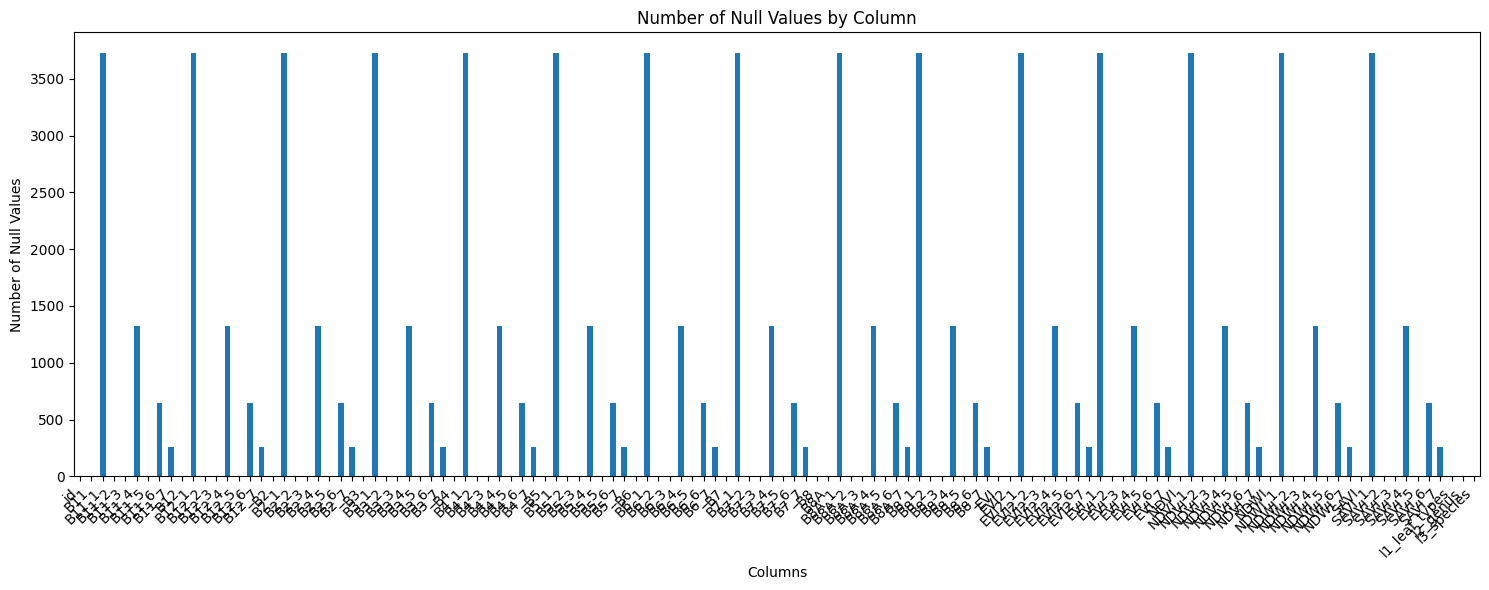

In [34]:
plt.figure(figsize=(15, 6))
nullds_td[nullds_td >= 0].plot(kind='bar')
plt.title('Number of Null Values by Column')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [35]:
# drop rows containing null values
select_df_td = select_df_td.dropna()

# drop rows containing 'none' (in any case) in any column
select_df_td = select_df_td[~select_df_td.apply(lambda row: row.astype(str).str.lower().eq('none').any(), axis=1)]

nullds_td = select_df_td.isnull().sum()
print(nullds_td)

id               0
B11              0
B11_1            0
B11_2            0
B11_3            0
                ..
SAVI_6           0
SAVI_7           0
l1_leaf_types    0
l2_genus         0
l3_species       0
Length: 124, dtype: int64


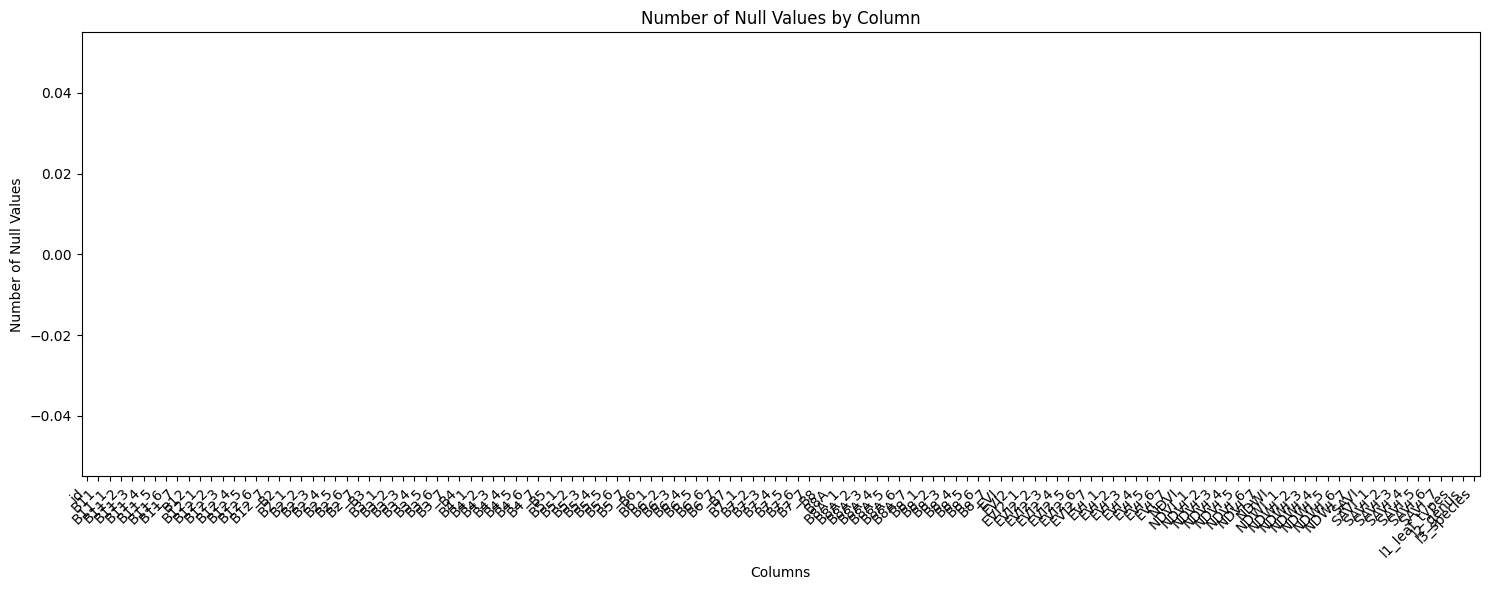

In [36]:
plt.figure(figsize=(15, 6))
nullds_td[nullds_td >= 0].plot(kind='bar')
plt.title('Number of Null Values by Column')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [37]:
# load the labels
labels_td = np.array(select_df_td[['l1_leaf_types', 'l2_genus','l3_species']])
sen2_td = np.array(select_df_td[['B11', 'B11_1', 'B11_2', 'B11_3', 'B11_4', 'B11_5', 'B11_6', 'B12', 'B12_1', 'B12_2', 'B12_3', 'B12_4', 'B12_5', 'B12_6', 'B2', 'B2_1', 'B2_2', 'B2_3', 'B2_4', 'B2_5', 'B2_6', 'B3', 'B3_1', 'B3_2', 'B3_3', 'B3_4', 'B3_5', 'B3_6', 'B4', 'B4_1', 'B4_2', 'B4_3', 'B4_4', 'B4_5', 'B4_6', 'B5', 'B5_1', 'B5_2', 'B5_3', 'B5_4', 'B5_5', 'B5_6', 'B6', 'B6_1', 'B6_2', 'B6_3', 'B6_4', 'B6_5', 'B6_6', 'B7', 'B7_1', 'B7_2', 'B7_3', 'B7_4', 'B7_5', 'B7_6', 'B8', 'B8A', 'B8A_1', 'B8A_2','B8A_3', 'B8A_4', 'B8A_5', 'B8A_6', 'B8_1', 'B8_2', 'B8_3', 'B8_4', 'B8_5', 'B8_6', 'EVI', 'EVI2', 'EVI2_1', 'EVI2_2', 'EVI2_3', 'EVI2_4', 'EVI2_5', 'EVI2_6', 'EVI_1', 'EVI_2', 'EVI_3', 'EVI_4', 'EVI_5', 'EVI_6','NDVI', 'NDVI_1', 'NDVI_2', 'NDVI_3', 'NDVI_4', 'NDVI_5', 'NDVI_6', 'NDWI', 'NDWI_1', 'NDWI_2', 'NDWI_3', 'NDWI_4', 'NDWI_5', 'NDWI_6', 'SAVI', 'SAVI_1', 'SAVI_2', 'SAVI_3', 'SAVI_4', 'SAVI_5', 'SAVI_6']])
# show the shape
print("Labels shape: " + str(labels_td.shape))
#print("Sen2 shape: " + str(sen2.shape))

# print the labels
print(labels_td[:])
print(sen2_td[:])
print(sen2_td.shape)

Labels shape: (3792, 3)
[['needleleaf' 'pine' 'scots pine']
 ['needleleaf' 'pine' 'scots pine']
 ['needleleaf' 'pine' 'scots pine']
 ...
 ['broadleaf' 'oak' 'english oak']
 ['broadleaf' 'oak' 'english oak']
 ['broadleaf' 'oak' 'english oak']]
[['[ [ 0.18850000202655792, 0.18850000202655792, 0.20579999685287476, 0.20579999685287476, 0.20579999685287476 ], [ 0.18850000202655792, 0.18850000202655792, 0.20579999685287476, 0.20579999685287476, 0.20579999685287476 ], [ 0.18269999325275421, 0.18269999325275421, 0.19840000569820404, 0.19840000569820404, 0.19840000569820404 ], [ 0.18269999325275421, 0.18269999325275421, 0.19840000569820404, 0.19840000569820404, 0.19840000569820404 ], [ 0.18389999866485596, 0.18389999866485596, 0.19859999418258667, 0.19859999418258667, 0.19859999418258667 ] ]'
  '[ [ 0.19804999232292175, 0.19804999232292175, 0.21400000154972076, 0.21400000154972076, 0.21400000154972076 ], [ 0.19804999232292175, 0.19804999232292175, 0.21400000154972076, 0.21400000154972076, 0.214

In [38]:
# load the labels
labels_l1_td = np.array(select_df_td[['l1_leaf_types']])
labels_l2_td = np.array(select_df_td[['l2_genus']])
labels_l3_td = np.array(select_df_td[['l3_species']])


encoder = OneHotEncoder(sparse_output=False)
labels_l1_td = encoder.fit_transform(labels_l1_td.reshape(-1, 1))
labels_l2_td = encoder.fit_transform(labels_l2_td.reshape(-1, 1))
labels_l3_td = encoder.fit_transform(labels_l3_td.reshape(-1, 1))

In [39]:
print("Initial shapes:")
print(f"labels_l1: {labels_l1_td.shape}")
print(f"labels_l2: {labels_l2_td.shape}")
print(f"labels_l3: {labels_l3_td.shape}")
print(f"sen2: {sen2_td.shape}")

print(labels_l1_td.dtype)
print(labels_l2_td.dtype)
print(labels_l3_td.dtype)
print(sen2_td.dtype)

Initial shapes:
labels_l1: (3792, 2)
labels_l2: (3792, 9)
labels_l3: (3792, 19)
sen2: (3792, 105)
float64
float64
float64
object


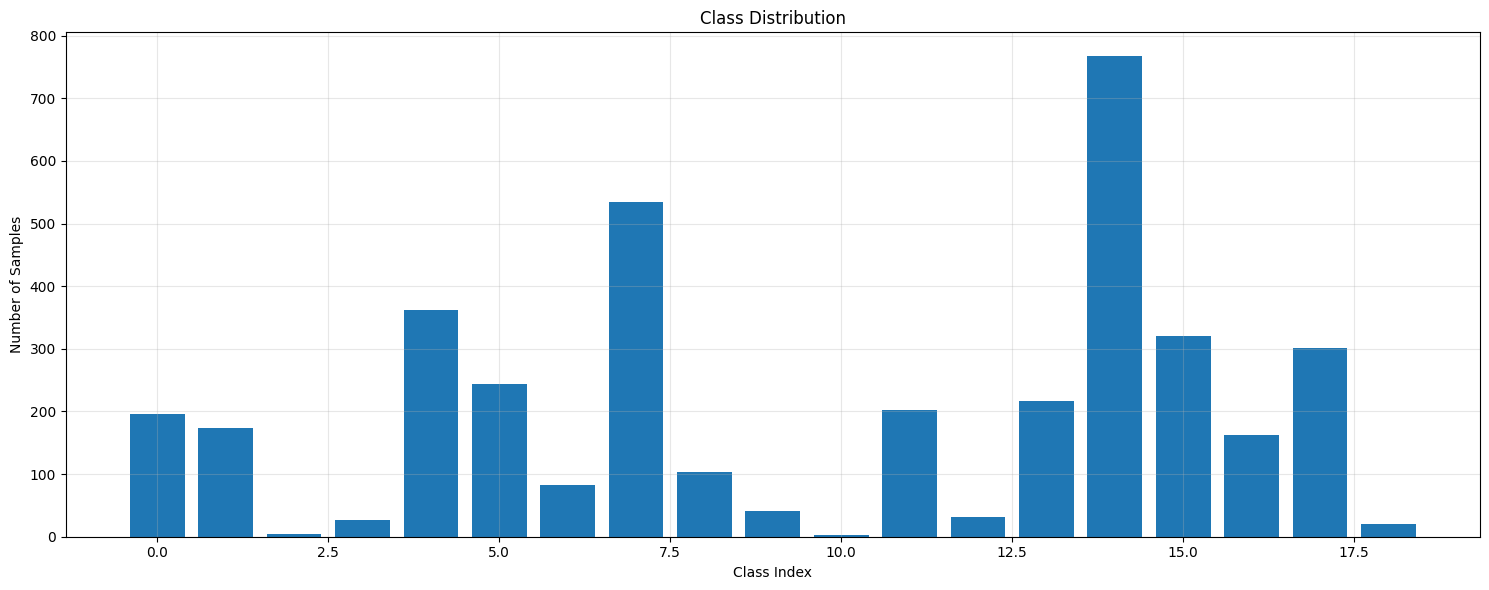

In [40]:
# Get the sum of each column (class counts)
class_sizes = np.sum(labels_l3_td, axis=0)

# Create a bar plot
plt.figure(figsize=(15, 6))
plt.bar(range(len(class_sizes)), class_sizes)

# Add labels and title
plt.title('Class Distribution')
plt.xlabel('Class Index')
plt.ylabel('Number of Samples')

# Adjust layout
plt.tight_layout()

# Add grid for better readability
plt.grid(True, alpha=0.3)

In [41]:
# Convert string representation of arrays to actual numpy arrays
def convert_string_to_array(s):
	# Using ast.literal_eval to safely evaluate the string as a Python literal
	array_data = ast.literal_eval(s)
	return np.array(array_data)

# Convert all elements in sen2 to numpy arrays
sen2_td_arrays = np.array([convert_string_to_array(x) for x in sen2_td.flatten()])
number_samples = sen2_td.shape[0]
sen2_td_reshaped = sen2_td_arrays.reshape(number_samples, -1)

print("Post-processed Sentinel-2 data shape: ", sen2_td_reshaped.shape)

Post-processed Sentinel-2 data shape:  (3792, 2625)


In [42]:
# Create a dictionary for multiple classes
sampling_strategy = {
    0: 5000,
    1: 5000,
    2: 5000,  
    3: 5000,
    4: 5000,  
    5: 5000,   
    6: 5000,
    7: 5000,
    8: 5000,
    9: 5000,
    10: 5000,
    11: 5000,
    12: 5000,
    13: 5000,
    14: 5000,
    15: 5000,
    16: 5000,
    17: 5000,
    18: 5000
}

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=5)
X_td_resampled, l3_td_resampled = smote.fit_resample(sen2_td_reshaped, np.argmax(labels_l3_td, axis=1))  


# Update the labels_l3 with the resampled data
labels_l3_td_resampled = encoder.fit_transform(l3_td_resampled.reshape(-1, 1))

ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 5, n_samples = 5

In [43]:
print("Resampled shapes:", X_td_resampled.shape, labels_l3_td_resampled.shape)

# Get the sum of each column (class counts)
class_sizes = np.sum(labels_l3_td_resampled, axis=0)

# Create a bar plot
plt.figure(figsize=(15, 6))
plt.bar(range(len(class_sizes)), class_sizes)

# Add labels and title
plt.title('Class Distribution')
plt.xlabel('Class Index')
plt.ylabel('Number of Samples')

# Adjust layout
plt.tight_layout()

# Add grid for better readability
plt.grid(True, alpha=0.3)

NameError: name 'X_td_resampled' is not defined

In [44]:
print("X_td_resampled:", sen2_td_reshaped.shape) # X_resampled: (97400, 2625)
X_td_reshaped = sen2_td_reshaped.reshape(-1, 5, 5, sen2_td_reshaped.shape[1] // 25)
print("X_td_resampled:", X_td_reshaped.shape)
print(f"labels_l1: {labels_l1_td.shape}")
print(f"labels_l2: {labels_l2_td.shape}")
print(f"labels_l3: {labels_l3_td.shape}")

X_td_resampled: (3792, 2625)
X_td_resampled: (3792, 5, 5, 105)
labels_l1: (3792, 2)
labels_l2: (3792, 9)
labels_l3: (3792, 19)


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy on new data:
L1: 0.7967
L2: 0.1959
L3: 0.5303


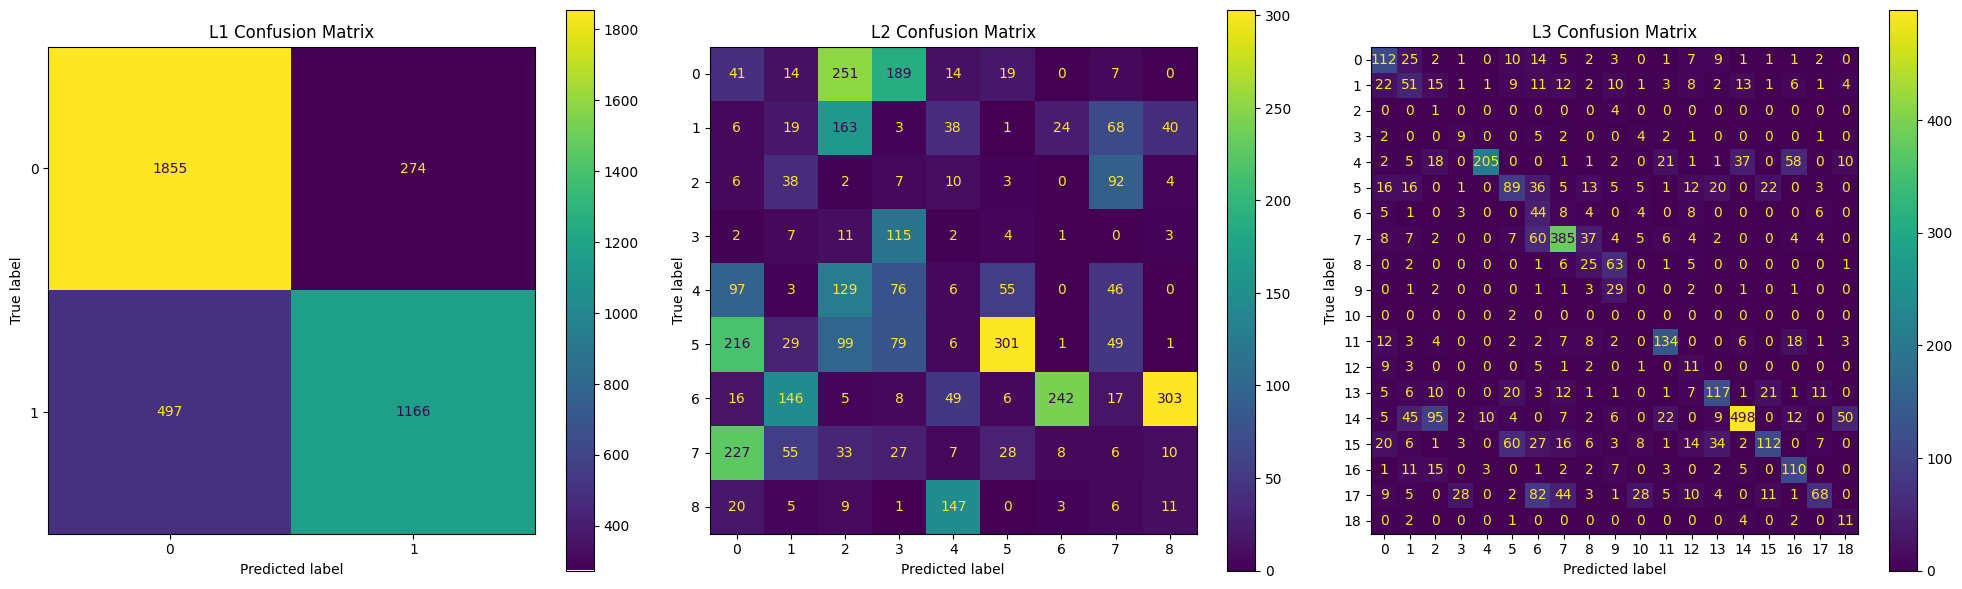

In [76]:
X_td, labels_l1_resampled, labels_l2_resampled, labels_l3_resampled = X_td_reshaped, labels_l1_td, labels_l2_td, labels_l3_td

# Predict with the already trained hierarchical CNN models
l1_preds = l1_model.predict(X_td)
l2_preds = l2_model.predict([X_td, l1_preds])
l3_preds = l3_model.predict([X_td, l1_preds, l2_preds])

# Convert predictions and ground truth to integer labels
l1_preds_int = np.argmax(l1_preds, axis=1)
l2_preds_int = np.argmax(l2_preds, axis=1)
l3_preds_int = np.argmax(l3_preds, axis=1)

y_l1_td_int = np.argmax(labels_l1_resampled, axis=1)
y_l2_td_int = np.argmax(labels_l2_resampled, axis=1)
y_l3_td_int = np.argmax(labels_l3_resampled, axis=1)

# Calculate accuracies
l1_acc = accuracy_score(y_l1_td_int, l1_preds_int)
l2_acc = accuracy_score(y_l2_td_int, l2_preds_int)
l3_acc = accuracy_score(y_l3_td_int, l3_preds_int)

print("Accuracy on new data:")
print(f"L1: {l1_acc:.4f}")
print(f"L2: {l2_acc:.4f}")
print(f"L3: {l3_acc:.4f}")

# Plot confusion matrices
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ConfusionMatrixDisplay.from_predictions(y_l1_td_int, l1_preds_int, ax=ax1)
ax1.set_title('L1 Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_l2_td_int, l2_preds_int, ax=ax2)
ax2.set_title('L2 Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_l3_td_int, l3_preds_int, ax=ax3)
ax3.set_title('L3 Confusion Matrix')
plt.tight_layout()
plt.show()
